          PL Intensity (kcps)
Time (s)                     
0.01                     36.9
0.02                     34.9
0.03                     36.9
0.04                     37.5
0.05                     35.8


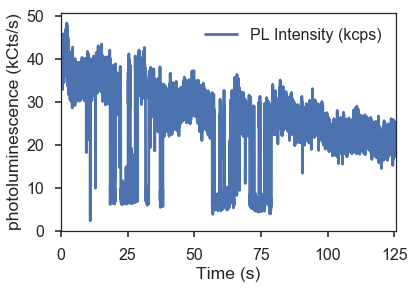

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 27 17:17:43 2018

Blinker analysis

@author: Viva Horowitz
"""

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import seaborn as sns
sns.set(style='ticks')
sns.set_context('poster')

datadate = '2018-05-25'
datafolder = r'O:\User\Viva\data\2018-05-25_blinking-statistics'
filename = 'GoodBlinker_5-25-2018.txt'
analysisfolder = r'O:\User\Viva\analysis\blinker_analysis'

os.chdir(datafolder)

tname = 'Time (s)'
PLname = 'PL Intensity (kcps)'

data = pd.read_csv(filename,
                   skiprows=1,
                   header=None,
                   sep='\t',
                   names=['Time (s)','PL Intensity (kcps)'],
                   usecols=[0,1])

data = data.set_index(tname)
print(data.head())

data.plot()
plt.ylabel('photoluminescence (kCts/s)')
plt.show()

filename = filename.replace('\\','-')
os.chdir(analysisfolder)
today = datetime.date.isoformat(datetime.date.today())
if not os.path.exists('taken-' + datadate):
    os.makedirs('taken-' + datadate)
os.chdir('taken-' + datadate)

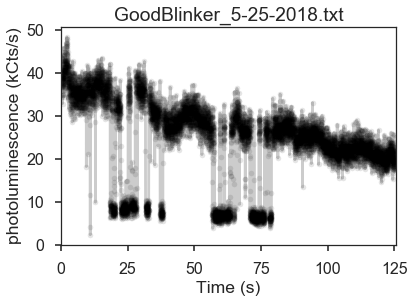

In [2]:
fig1,axPL = plt.subplots()
#axPL.plot(data, 'k')
#axPL.legend.remove()
data.plot(marker='.',linestyle='None',legend=False, ax=axPL, color='k',  alpha=.1)
data.plot(legend=False, alpha=0.2, ax=axPL, color='k')
plt.ylabel('photoluminescence (kCts/s)')
plt.xlabel(tname)

plt.title(filename)

plt.savefig(today + ',' + filename+',blinking.pdf', bbox_inches='tight')
plt.savefig(today + ',' + filename+',blinking.png', bbox_inches='tight', dpi=200)

plt.show()

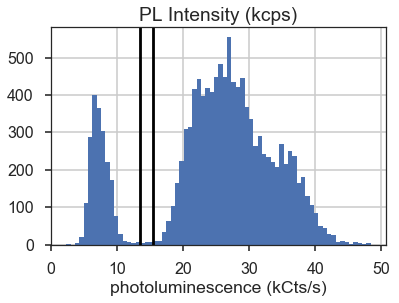

In [3]:
data.hist(bins=70)
plt.xlabel('photoluminescence (kCts/s)')
plt.locator_params(axis='x', nbins=10)
ax = plt.gca()

# Need to pick an appropriate threshold between on and off. 
uthreshold = 15.5
lthreshold = uthreshold-2

ax.axvline(x=uthreshold, color='k')
ax.axvline(x=lthreshold, color = 'k')
#ax.tick_params(axis='x',which='minor',bottom='on')
#ax.xaxis.set_minor_locator(minorLocator)
plt.show()

In [4]:
# The data was collected at a particular rate
timesetting = data.index[1]-data.index[0]
timesetting

0.01

In [5]:
data.head()

,PL Intensity (kcps)
Time (s),
0.01,36.9
0.02,34.9
0.03,36.9
0.04,37.5
0.05,35.8


In [6]:
data.count()

PL Intensity (kcps)    12570
dtype: int64

In [7]:
data.describe()

,PL Intensity (kcps)
count,12570.000000
mean,24.785386
std,9.308945
min,2.300000
25%,21.100000
50%,26.000000
75%,30.900000
max,48.400000


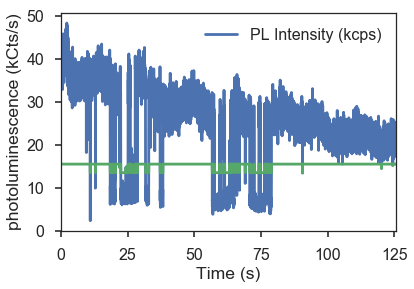

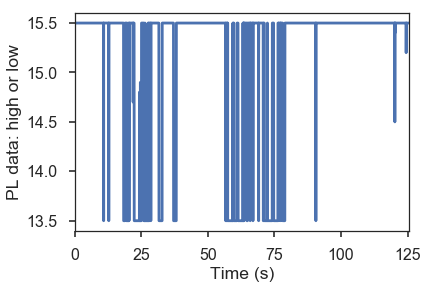

In [8]:
# With an uthreshold and an lthreshold
# This code has an in between status where it won't be counted as remaining in the state 
# but it won't be counted in the other state, either. 
# This seems like the most straightforward way to deal with (rare) cases in between.
# Other options are shown.


threshdata = data[PLname].clip(upper=uthreshold, lower=lthreshold)

data.plot()
plt.ylabel('photoluminescence (kCts/s)')
threshdata.plot()

plt.figure()
threshdata.plot()
plt.ylabel('PL data: high or low')
plt.show()


In [9]:
# Main method: in between status where it won't be counted as remaining in the state 
# but it won't be counted in the other state, either.
downtimes2= threshdata[threshdata != uthreshold].index
uptimes2=threshdata[threshdata != lthreshold].index

print(uptimes2)
print(downtimes2)

Float64Index([  0.01,   0.02,   0.03,   0.04,   0.05,   0.06,   0.07,   0.08,
                0.09,    0.1,
              ...
              125.61, 125.62, 125.63, 125.64, 125.65, 125.66, 125.67, 125.68,
              125.69,  125.7],
             dtype='float64', name=u'Time (s)', length=10551)
Float64Index([  10.9,  10.91,  10.92,  12.84,  18.38,  18.39,   18.4,  18.41,
               18.42,  18.43,
              ...
               78.88,  78.89,   78.9,  78.91,  78.92,  78.93,  90.59, 120.24,
              120.29, 124.48],
             dtype='float64', name=u'Time (s)', length=2037)


In [10]:
# Alternate option (not used)
uptimes= threshdata[threshdata == uthreshold].index
downtimes=threshdata[threshdata == lthreshold].index

print(uptimes)
print(downtimes)

Float64Index([  0.01,   0.02,   0.03,   0.04,   0.05,   0.06,   0.07,   0.08,
                0.09,    0.1,
              ...
              125.61, 125.62, 125.63, 125.64, 125.65, 125.66, 125.67, 125.68,
              125.69,  125.7],
             dtype='float64', name=u'Time (s)', length=10533)
Float64Index([ 10.9, 10.91, 10.92, 12.84, 18.38, 18.39,  18.4, 18.41, 18.42,
              18.43,
              ...
              78.85, 78.86, 78.87, 78.88, 78.89,  78.9, 78.91, 78.92, 78.93,
              90.59],
             dtype='float64', name=u'Time (s)', length=2019)


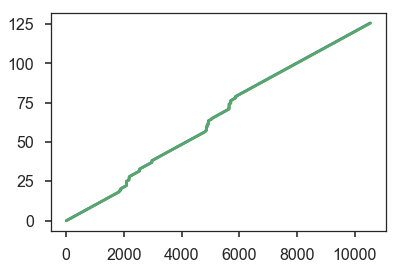

In [11]:
plt.plot(uptimes)
plt.plot(uptimes2)
plt.show()

In [12]:
uptimes[:-1]

Float64Index([  0.01,   0.02,   0.03,   0.04,   0.05,   0.06,   0.07,   0.08,
                0.09,    0.1,
              ...
               125.6, 125.61, 125.62, 125.63, 125.64, 125.65, 125.66, 125.67,
              125.68, 125.69],
             dtype='float64', name=u'Time (s)', length=10532)

In [13]:
uptimes[1:]

Float64Index([  0.02,   0.03,   0.04,   0.05,   0.06,   0.07,   0.08,   0.09,
                 0.1,   0.11,
              ...
              125.61, 125.62, 125.63, 125.64, 125.65, 125.66, 125.67, 125.68,
              125.69,  125.7],
             dtype='float64', name=u'Time (s)', length=10532)

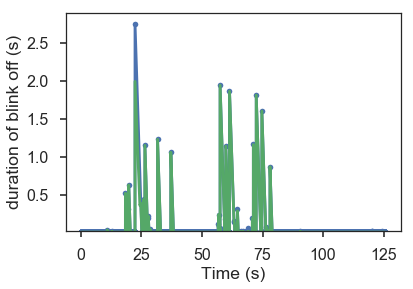

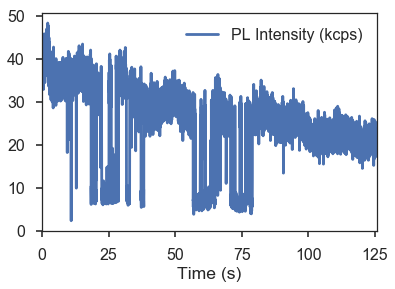

In [14]:
# We can compare the two ways of interpreting blinks.
# There is a discrepancy at about 22 seconds between the two interpretations. 
# It's a matter of whether we consider it stayed off or 
# if we consider that it came up enough to have ended the off blink and began another.
# I tend to think it ended one and began another in this case, so I'm going to use uptimesep2 as my off duration.

# subtracting each time from the last time we had the same state gives the amount of time it was not in that state.
# Therefore the separation between up times is in fact the duration of time off.
uptimesep = uptimes[1:] - uptimes[:-1]
uptimesep2 = uptimes2[1:] - uptimes2[:-1]
plt.plot(uptimes[:-1],uptimesep, '.-')
plt.plot(uptimes2[:-1],uptimesep2, '-')
plt.ylim(ymin=3*timesetting)
#plt.axis('equal')
plt.xlabel(tname)
plt.ylabel('duration of blink off (s)')
plt.figure()
data.plot()
plt.show()

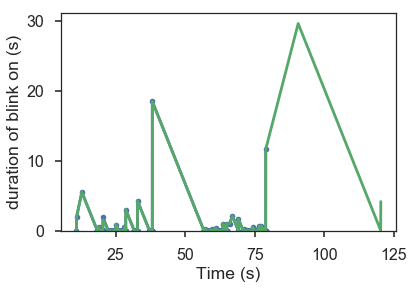

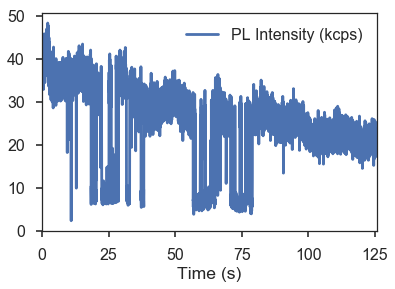

In [15]:
# We can compare the two ways of interpreting blinks. It looks like they mostly agree.

downtimesep = downtimes[1:] - downtimes[:-1]
downtimesep2 = downtimes2[1:] - downtimes2[:-1]
plt.plot(downtimes[:-1],downtimesep,'.-')
plt.plot(downtimes2[:-1],downtimesep2,'-')
plt.ylim(ymin=3*timesetting)
#plt.axis('equal')
plt.xlabel(tname)
plt.ylabel('duration of blink on (s)')
#plt.figure()
data.plot()
plt.show()

In [16]:
downtimesep2

Float64Index([            0.01,             0.01,             1.92,
                          5.54,             0.01,             0.01,
                          0.01,             0.01,             0.01,
                          0.01,
              ...
              0.00999999999999,             0.01,             0.01,
              0.00999999999999,             0.01,             0.01,
                         11.66,            29.65,             0.05,
                          4.19],
             dtype='float64', name=u'Time (s)', length=2036)

In [17]:
# I chose to use downtimesep2 and uptimesep2, as detailed above.

ontimes = filter(lambda a: a > 1.5*timesetting, downtimesep2)
offtimes = filter(lambda a: a > 1.5*timesetting, uptimesep2)

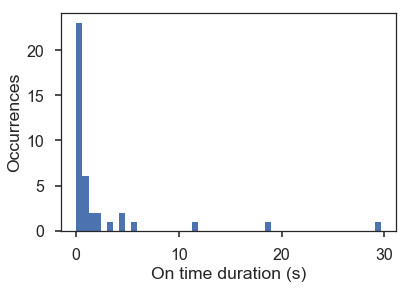

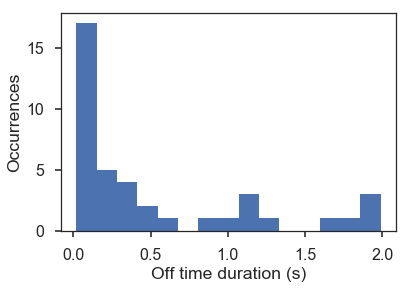

In [18]:
# Choose a nice number of bins to see how the data look.

numonbins = 50
numoffbins = 15

plt.hist(ontimes, bins=numonbins)
plt.xlabel('On time duration (s)')
plt.ylabel('Occurrences')
plt.show()
plt.hist(offtimes, bins=numoffbins)
plt.xlabel('Off time duration (s)')
plt.ylabel('Occurrences')
plt.show()

In [19]:
## https://stackoverflow.com/questions/32765333/how-do-i-replicate-this-matlab-function-in-numpy/32765547#32765547

def histc(X, bins):
    map_to_bins = np.digitize(X,bins)
    r = np.zeros(bins.shape)
    for i in map_to_bins:
        r[i-1] += 1
    return [r, map_to_bins]

In [20]:
# http://code.activestate.com/recipes/66472-frange-a-range-function-with-float-increments/
# could also use linspace

def frange(start, end=None, inc=None):
    "A range function, that does accept float increments..."

    if end == None:
        end = start + 0.0
        start = 0.0

    if inc == None:
        inc = 1.0

    L = []
    while 1:
        next = start + len(L) * inc
        if inc > 0 and next >= end:
            break
        elif inc < 0 and next <= end:
            break
        L.append(next)
        
    return L

In [21]:
## I decided to start my bins at 0. 
# This might be different from the built in hist function.

oninc = max(ontimes)/numonbins
onbins= frange(0,max(ontimes)+oninc*3,oninc)
#print(onbins[0:5])


offinc = max(offtimes)/numoffbins
offbins=np.linspace(0,max(offtimes),numoffbins+1)
print("linspace option (not used):")
print(offbins)
offbins= frange(0,max(offtimes),offinc)
print("frange approach:")
print(offbins)
#print(offbins[0:5])
offbins= frange(0,max(offtimes)+offinc*3,offinc)
print("frange approach and pad 3 bins to right (used):")
print(offbins)

centeredonbins = frange(oninc/2,max(ontimes)+oninc*3+oninc/2,oninc)
centeredoffbins= frange(offinc/2,max(offtimes)+offinc*3+offinc/2,offinc)
#centeredoffbins=np.linspace(offinc/2,max(offtimes)+offinc/2,numoffbins)


print('\n')
print(onbins[-5:])
print(centeredonbins[-5:])

print("Make sure ")
print(len(centeredonbins))
print(len(onbins))
print(len(centeredoffbins))
print(len(offbins))

linspace option (not used):
[ 0.          0.13266667  0.26533333  0.398       0.53066667  0.66333333
  0.796       0.92866667  1.06133333  1.194       1.32666667  1.45933333
  1.592       1.72466667  1.85733333  1.99      ]
frange approach:
[0.0, 0.13266666666666657, 0.26533333333333314, 0.39799999999999969, 0.53066666666666629, 0.66333333333333289, 0.79599999999999937, 0.92866666666666597, 1.0613333333333326, 1.1939999999999991, 1.3266666666666658, 1.4593333333333323, 1.5919999999999987, 1.7246666666666655, 1.8573333333333319]
frange approach and pad 3 bins to right (used):
[0.0, 0.13266666666666657, 0.26533333333333314, 0.39799999999999969, 0.53066666666666629, 0.66333333333333289, 0.79599999999999937, 0.92866666666666597, 1.0613333333333326, 1.1939999999999991, 1.3266666666666658, 1.4593333333333323, 1.5919999999999987, 1.7246666666666655, 1.8573333333333319, 1.9899999999999987, 2.1226666666666651, 2.2553333333333319]


[28.463999999999992, 29.056999999999992, 29.649999999999991, 30

In [22]:
onhist = histc(ontimes, np.asarray(onbins))
offhist = histc(offtimes, np.asarray(offbins))

In [23]:
onhist

[array([ 23.,   6.,   2.,   2.,   0.,   1.,   0.,   2.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.]),
 array([ 4, 10,  1,  1,  1,  3,  1,  2,  1,  1,  1,  1,  6,  8, 32,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  4,  3,  1,  1,  1,  1,
         2,  2, 20, 51,  1,  8], dtype=int64)]

In [24]:
offhist

[array([ 15.,   7.,   4.,   2.,   1.,   0.,   1.,   1.,   3.,   1.,   0.,
          0.,   1.,   1.,   3.,   0.,   0.,   0.]),
 array([ 1,  1,  4,  3,  5,  1, 15,  3,  3,  4,  9,  2,  2,  1, 10,  8,  1,
         2,  1, 15,  2,  1,  9, 15,  2,  2,  1,  3,  1,  1,  1,  1,  2,  9,
        14, 13,  1,  1,  7,  1], dtype=int64)]

red data are histogram data and black data are shifted to be centered on the bin


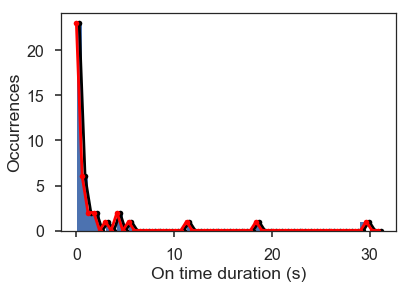

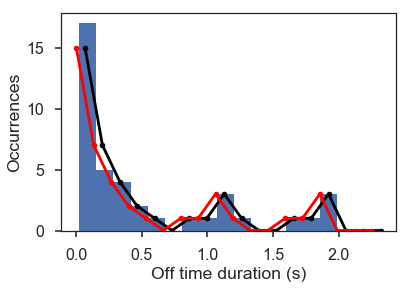

In [25]:
print("red data are histogram data and black data are shifted to be centered on the bin")

#fig, (ax1,ax2) = plt.subplots(2, 1, sharex=False)
fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'.-k')
ax1.plot(onbins,onhist[0],'.-r')
plt.hist(ontimes, bins=numonbins)
plt.xlabel('On time duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)

# Apparently my digitize and the hist function don't quite give the same output. 
# I think the hist command doesn't start at zero.
# Either way is probably fine.

#plt.yscale('log')
#plt.show()
fig,ax2 = plt.subplots()
ax2.plot(centeredoffbins,offhist[0],'.-k')
ax2.plot(offbins,offhist[0],'.-r')
plt.hist(offtimes, bins=numoffbins)
plt.xlabel('Off time duration (s)')
plt.ylabel('Occurrences')
#ax2.set_yscale('symlog', linthreshy=1)
plt.show()

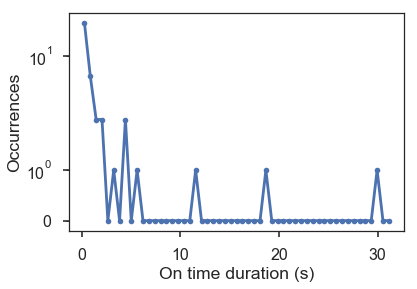

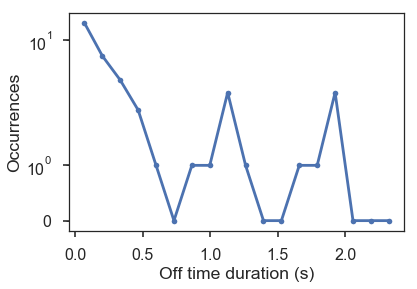

In [26]:
#fig, (ax1,ax2) = plt.subplots(2, 1, sharex=False)
fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'.-')
plt.xlabel('On time duration (s)')
plt.ylabel('Occurrences')
ax1.set_yscale('symlog', linthreshy=1)

#plt.yscale('log')
#plt.show()
fig,ax2 = plt.subplots()
ax2.plot(centeredoffbins,offhist[0],'.-')
plt.xlabel('Off time duration (s)')
plt.ylabel('Occurrences')
ax2.set_yscale('symlog', linthreshy=1)
plt.show()

In [27]:
from scipy.optimize import curve_fit
import scipy
scipy.__version__
# need at least version 14.0 of scipy.

'0.17.1'

In [28]:
def expfit(t, A, tau):
    return (A * np.exp(t/(-tau)))

In [29]:
# Create lists (run this again if you run the rest of the code)
onhistl = list(onhist[0])
centeredonbinstrunc = list(centeredonbins) # use the list command to make a copy   
offhistl = list(offhist[0])
centeredoffbinstrunc = list(centeredoffbins) # use the list command to make a copy

In [30]:
# Trying to find good guess
#onparams[1]=-.8
#onfit = 30 * np.exp(centeredonbins/(onparams[1]))

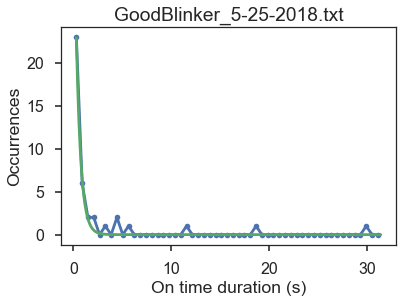

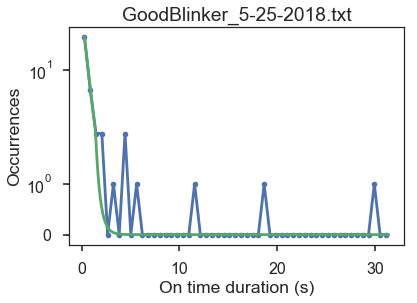

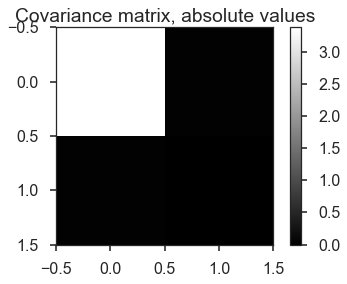

It's ok to use the uncertainties below as long as there aren't strong diagonal values.
Coefficient A = 43.1009364588 ± 1.83852212773
time constant tau = 0.46928332821 ± 0.0239177362052 sec


In [31]:
# on time fit
onparams, onpcov = curve_fit(expfit, centeredonbinstrunc, onhistl,p0 = (30, 0.8))
onfitx = np.linspace(min(centeredonbins),len(onhistl)*oninc,numonbins*5)
onfit = expfit(onfitx,onparams[0],onparams[1])

fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'.-')
plt.xlabel('On time duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(onfitx,onfit)
plt.title(filename)
plt.show()

fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'.-')
plt.xlabel('On time duration (s)')
plt.ylabel('Occurrences')
ax1.set_yscale('symlog', linthreshx=1)
ax1.plot(onfitx,onfit)
plt.title(filename)
plt.show()

plt.imshow(abs(onpcov), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, absolute values')
plt.show()
print("It's ok to use the uncertainties below as long as there aren't strong diagonal values.")



print  'Coefficient A = ' + str(onparams[0]) + ' ± ' + str(np.sqrt(onpcov[0,0]))
print 'time constant tau = ' + str(onparams[1]) + ' ± ' + str(np.sqrt(onpcov[1,1])) + ' sec'



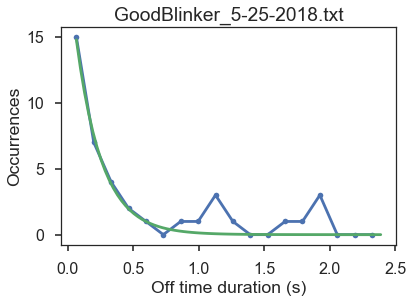

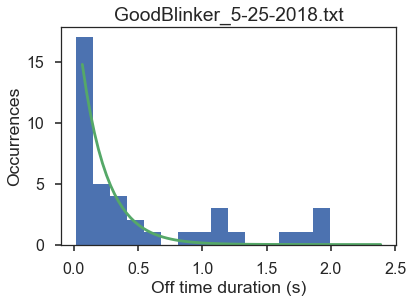

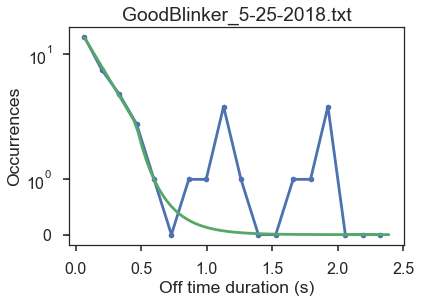

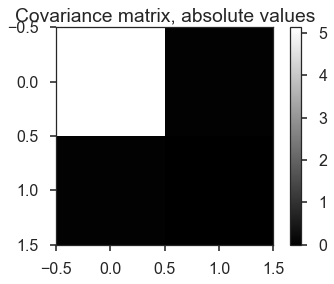

It's ok to use the uncertainties below as long as there aren't strong diagonal values.
Coefficient A = 20.7082393956 ± 2.2669875812
time constant tau = 0.197015196642 ± 0.0292364608915 sec


In [32]:
# off time fit
offparams, offpcov = curve_fit(expfit, centeredoffbinstrunc, offhistl,p0 = (30, 0.8))
offfitx = np.linspace(min(centeredoffbins),len(offhistl)*offinc,numoffbins*5)
offfit = expfit(offfitx,offparams[0],offparams[1])

# display
fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'.-')
plt.xlabel('Off time duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(offfitx,offfit)
plt.title(filename)
plt.show()

fig,ax1 = plt.subplots()
plt.hist(offtimes, bins=numoffbins)
plt.xlabel('Off time duration (s)')
plt.ylabel('Occurrences')
ax1.plot(offfitx,offfit)
plt.title(filename)
plt.show()

fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'.-')
plt.xlabel('Off time duration (s)')
plt.ylabel('Occurrences')
ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(offfitx,offfit)
plt.title(filename)
plt.show()

plt.imshow(abs(offpcov), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, absolute values')
plt.show()
print("It's ok to use the uncertainties below as long as there aren't strong diagonal values.")



print  'Coefficient A = ' + str(offparams[0]) + ' ± ' + str(np.sqrt(offpcov[0,0]))
print 'time constant tau = ' + str(offparams[1]) + ' ± ' + str(np.sqrt(offpcov[1,1])) + ' sec'

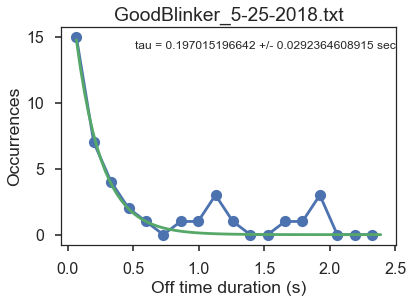

In [33]:
fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'o-')
plt.xlabel('Off time duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(offfitx,offfit)
plt.text(1.0,0.9,'tau = '  + str(offparams[1]) + ' +/- '  + str(np.sqrt(offpcov[1,1])) + ' sec',
         horizontalalignment='right', transform = ax1.transAxes, fontsize=12)
plt.title(filename)

plt.show()

off time constant tau = 0.197015196642 ± 0.0292364608915 sec
on time constant tau = 0.46928332821 ± 0.0239177362052 sec


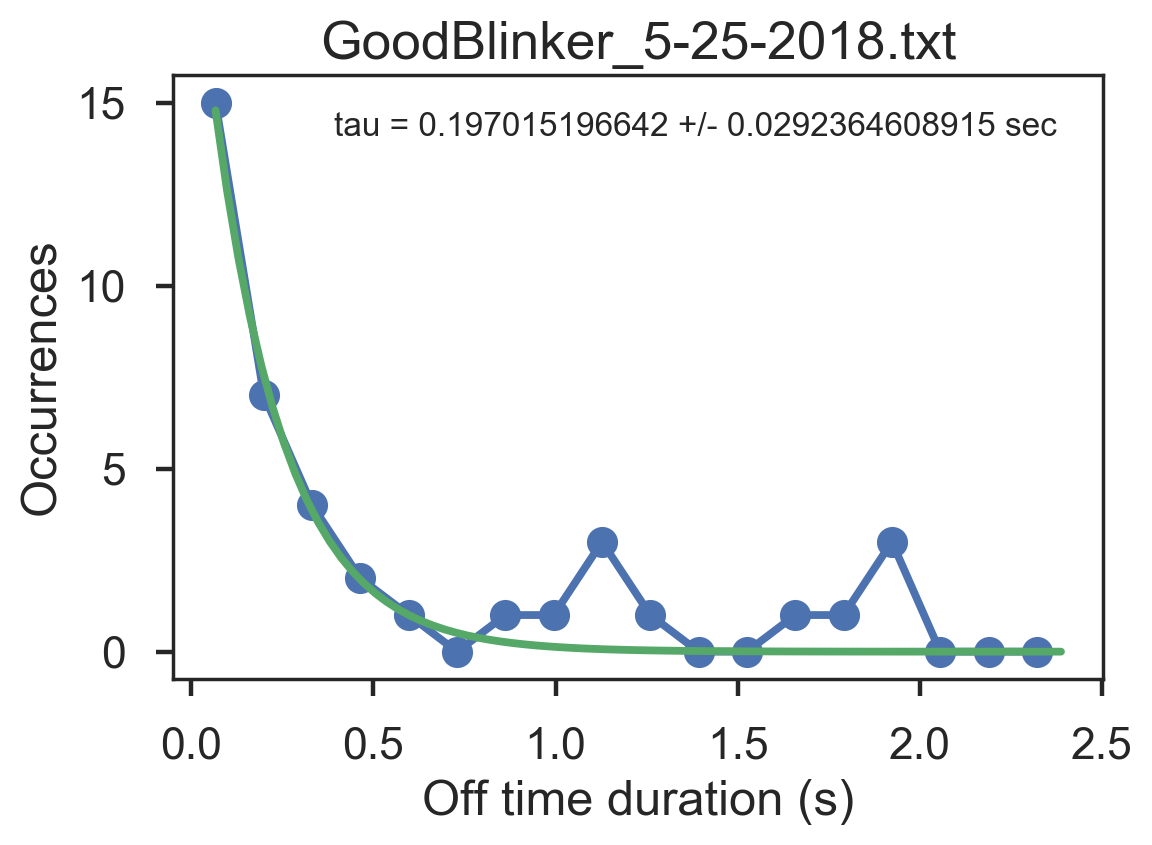

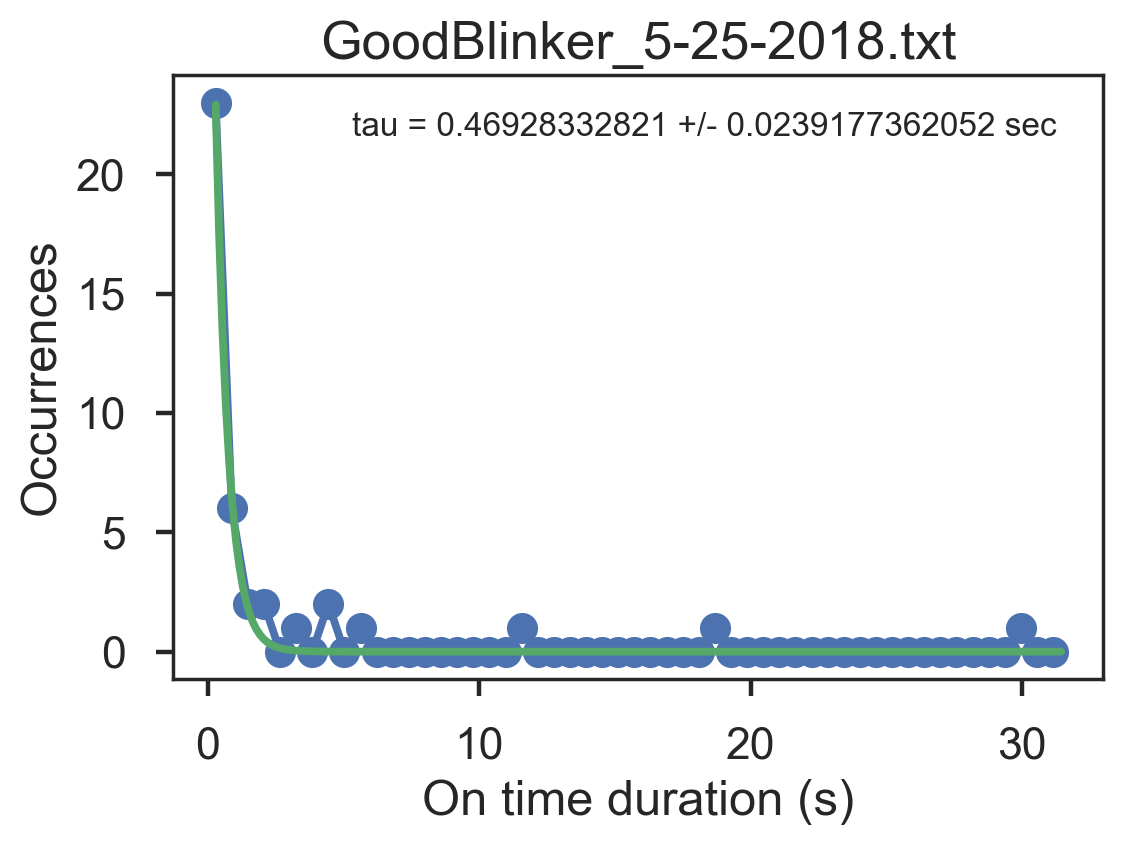

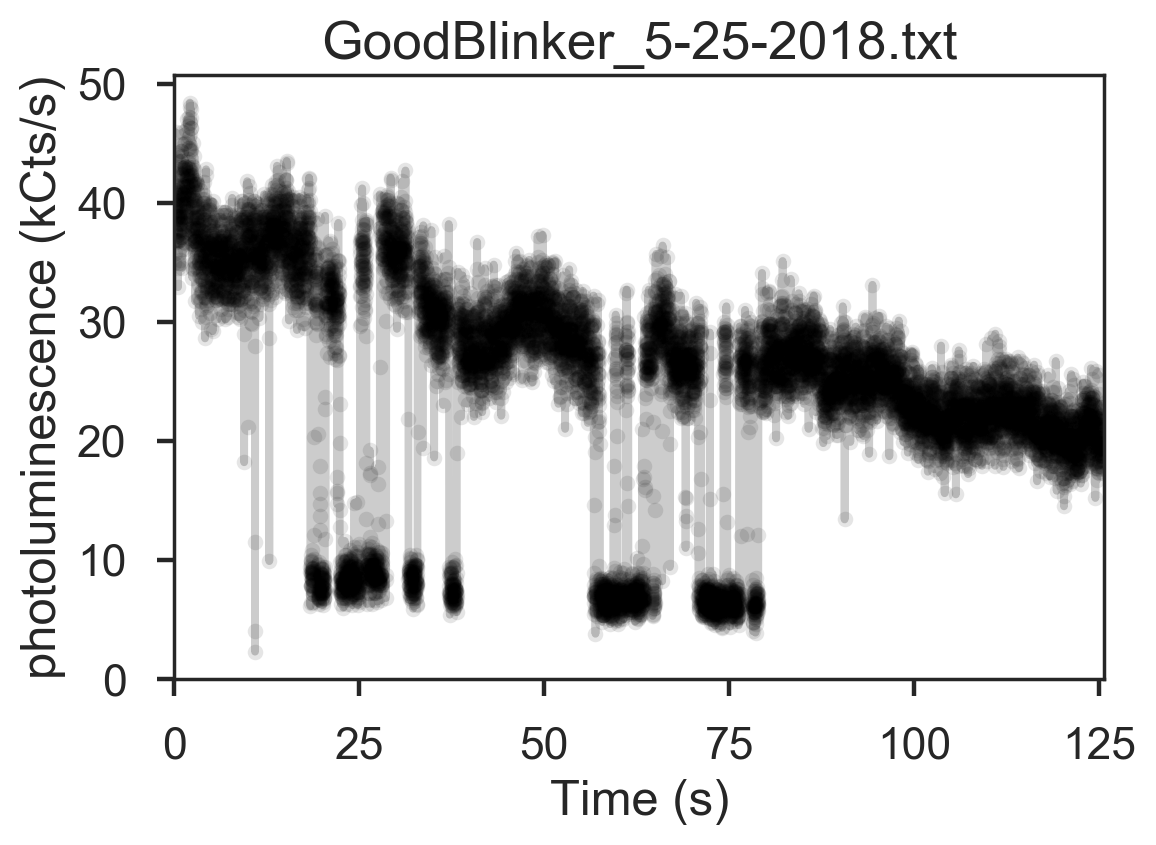

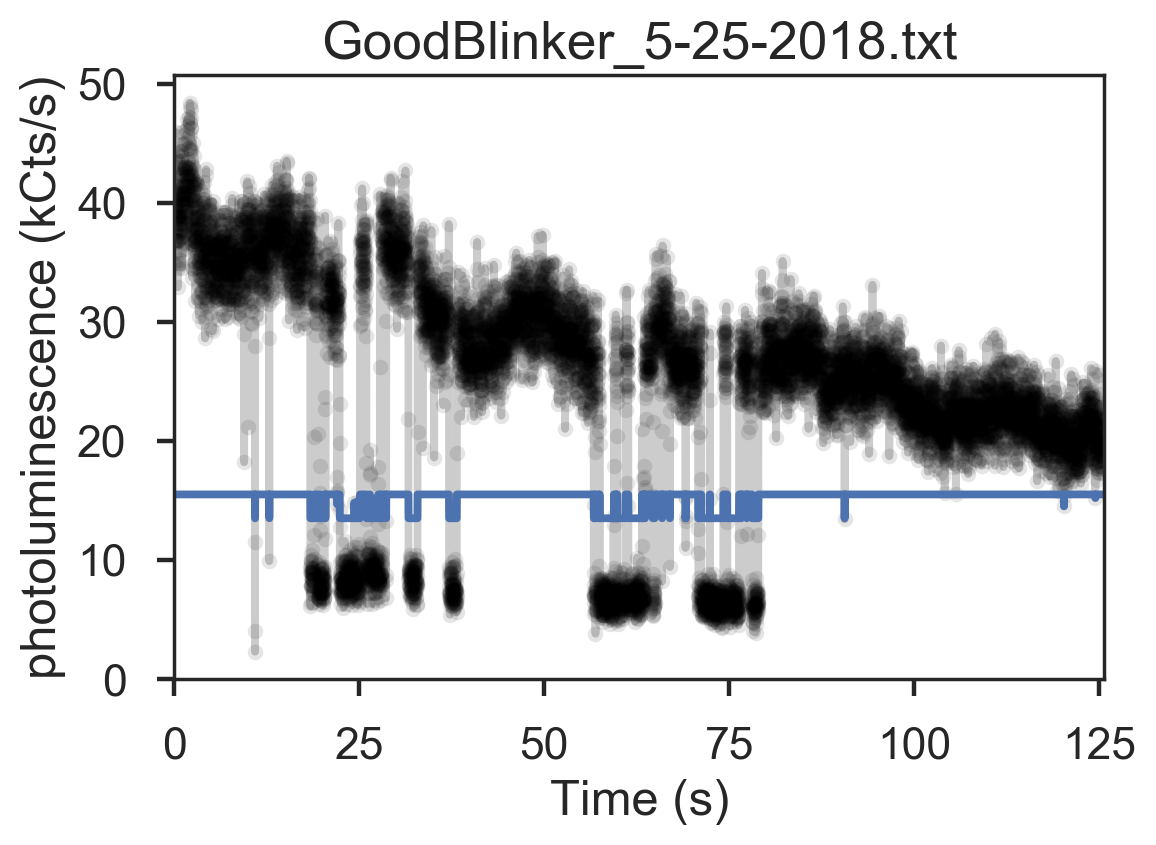

In [34]:
# Save figures

mpl.rcParams['figure.dpi'] = 200

font = {'size'   : 22}
plt.rc('font', **font)

infostr = ',fitpast0'

# display off blinks
fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'o-')
plt.xlabel('Off time duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(offfitx,offfit)
plt.text(0.95,0.9,'tau = '  + str(offparams[1]) + ' +/- '  + str(np.sqrt(offpcov[1,1])) + ' sec',
         horizontalalignment='right', transform = ax1.transAxes, fontsize=12)
plt.title(filename)

plt.savefig(today + ',' + filename+',offblinks' + infostr + '.pdf', bbox_inches='tight')
plt.savefig(today + ',' + filename+',offblinks' + infostr + '.png', bbox_inches='tight')

print 'off time constant tau = ' + str(offparams[1]) + ' ± ' + str(np.sqrt(offpcov[1,1])) + ' sec'


# On blinks
fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'o-')
plt.xlabel('On time duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(onfitx,onfit)
plt.text(0.95,0.9,'tau = '  + str(onparams[1]) + ' +/- '  + str(np.sqrt(onpcov[1,1])) + ' sec',
         horizontalalignment='right', transform = ax1.transAxes, fontsize=12)
plt.title(filename)

plt.savefig(today + ',' + filename+',onblinks' + infostr + '.pdf', bbox_inches='tight')
plt.savefig(today + ',' + filename+',onblinks' + infostr + '.png', bbox_inches='tight')


print 'on time constant tau = ' + str(onparams[1]) + ' ± ' + str(np.sqrt(onpcov[1,1])) + ' sec'

fig1,axPL = plt.subplots()
#axPL.plot(data, 'k')
#axPL.legend.remove()
data.plot(marker='.',linestyle='None',legend=False, ax=axPL, color='k',  alpha=.1)
data.plot(legend=False, alpha=0.2, ax=axPL, color='k')
plt.ylabel('photoluminescence (kCts/s)')
plt.xlabel(tname)
plt.title(filename)

plt.savefig(today + ',' + filename+',blinking.pdf', bbox_inches='tight')
plt.savefig(today + ',' + filename+',blinking.png', bbox_inches='tight')


fig2,axPL = plt.subplots()
data.plot(marker='.',linestyle='None',legend=False, alpha=0.1, ax=axPL, color='k')
data.plot(legend=False, alpha=0.2, ax=axPL, color='k')
threshdata.plot(legend=False)
plt.ylabel('photoluminescence (kCts/s)')
plt.xlabel(tname)
plt.title(filename)

plt.savefig(today + ',' + filename+',blinkingandthreshold.pdf', bbox_inches='tight')
plt.savefig(today + ',' + filename+',blinkingandthreshold.png', bbox_inches='tight')


plt.show()


In [35]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set(style='ticks')
sns.set_context('poster')

In [36]:
# reset in case I've already run this.
onhistl = list(onhist[0])
centeredonbinstrunc = list(centeredonbins) # use the list command to make a copy
offhistl = list(offhist[0])
centeredoffbinstrunc = list(centeredoffbins) # use the list command to make a copy

# cut off data above zero bin
zeroindexon = onhistl.index(0)
del onhistl[zeroindexon:]
del centeredonbinstrunc[zeroindexon:]
zeroindexoff = offhistl.index(0)
del offhistl[zeroindexoff:]
del centeredoffbinstrunc[zeroindexoff:]
    
infostr = ''

try:
    guessonparams = onparams
except:
    guessonparams=(30,0.8)
    
print('Guessing: ' + str(guessonparams))    
    
try:
    guessoffparams = offparams
except:
    guessoffparams = (30,0.8)
    
print('Guessing: ' + str(guessoffparams))

Guessing: [ 43.10093646   0.46928333]
Guessing: [ 20.7082394   0.1970152]


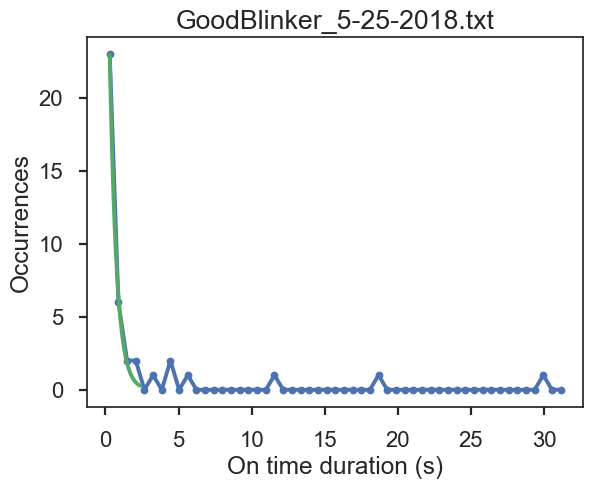

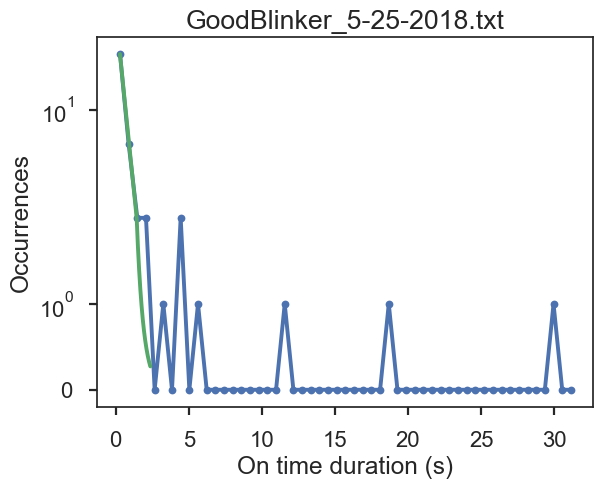

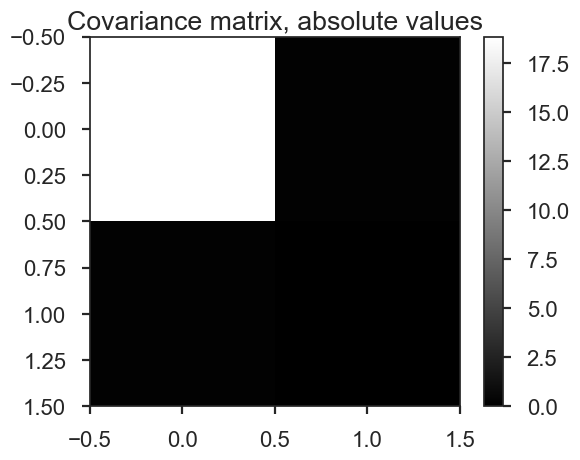

It's ok to use the uncertainties below as long as there aren't strong diagonal values.
Coefficient A = 43.182225149 ± 4.34429410618
time constant tau = 0.468065647664 ± 0.0562625487438 sec


In [37]:
# on time fit
onparams, onpcov = curve_fit(expfit, centeredonbinstrunc, onhistl,p0 = guessonparams)
onfitx = np.linspace(min(centeredonbins),len(onhistl)*oninc,numonbins*5)
onfit = expfit(onfitx,onparams[0],onparams[1])

fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'.-')
plt.xlabel('On time duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(onfitx,onfit)
plt.title(filename)
plt.show()

fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'.-')
plt.xlabel('On time duration (s)')
plt.ylabel('Occurrences')
ax1.set_yscale('symlog',linthreshx=1)
ax1.plot(onfitx,onfit)
plt.title(filename)
plt.show()

plt.imshow(abs(onpcov), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, absolute values')
plt.show()
print("It's ok to use the uncertainties below as long as there aren't strong diagonal values.")



print  'Coefficient A = ' + str(onparams[0]) + ' ± ' + str(np.sqrt(onpcov[0,0]))
print 'time constant tau = ' + str(onparams[1]) + ' ± ' + str(np.sqrt(onpcov[1,1])) + ' sec'



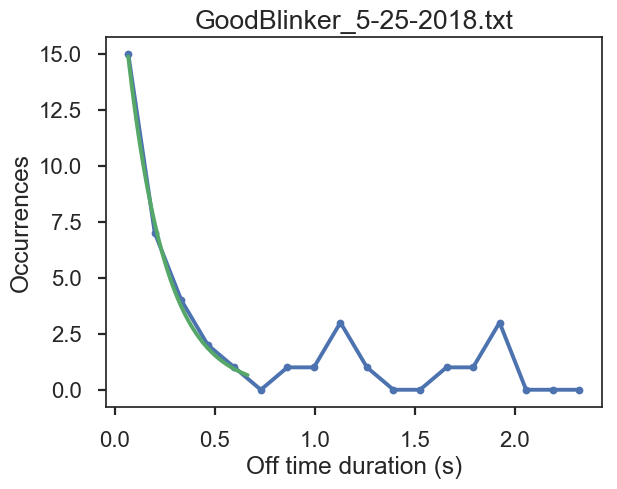

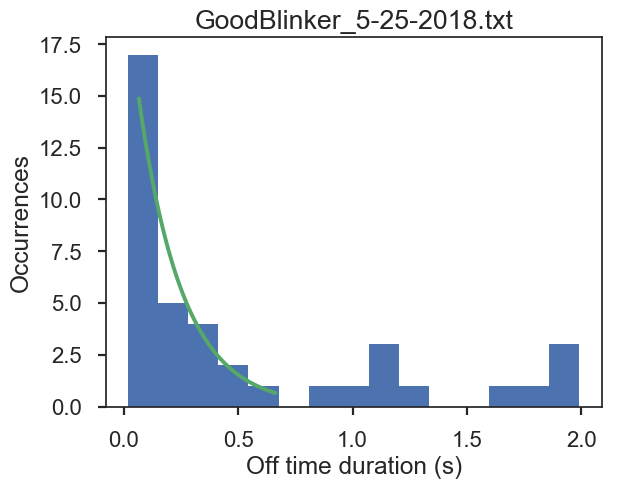

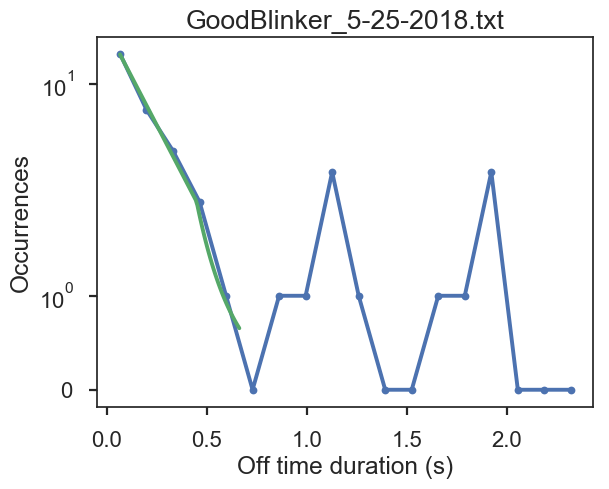

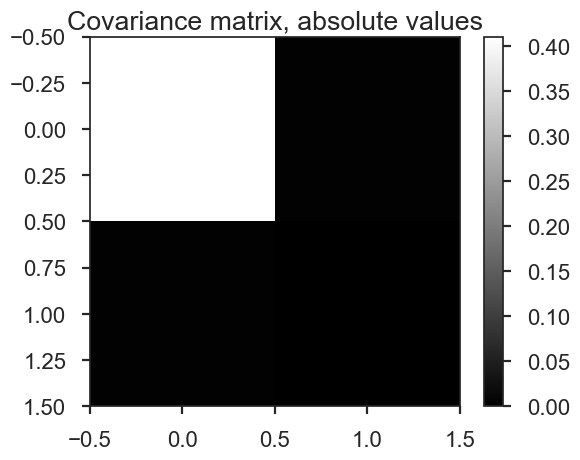

It's ok to use the uncertainties below as long as there aren't strong diagonal values.
Coefficient A = 21.0508274009 ± 0.64071820586
time constant tau = 0.191145081091 ± 0.00797806498132 sec


In [38]:
# off time fit
offparams, offpcov = curve_fit(expfit, centeredoffbinstrunc, offhistl,p0 = guessoffparams)
offfitx = np.linspace(min(centeredoffbins),len(offhistl)*offinc,numoffbins*5)
offfit = expfit(offfitx,offparams[0],offparams[1])

# display
fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'.-')
plt.xlabel('Off time duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(offfitx,offfit)
plt.title(filename)
plt.show()

fig,ax1 = plt.subplots()
plt.hist(offtimes, bins=numoffbins)
plt.xlabel('Off time duration (s)')
plt.ylabel('Occurrences')
ax1.plot(offfitx,offfit)
plt.title(filename)
plt.show()

fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'.-')
plt.xlabel('Off time duration (s)')
plt.ylabel('Occurrences')
ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(offfitx,offfit)
plt.title(filename)
plt.show()

plt.imshow(abs(offpcov), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, absolute values')
plt.show()
print("It's ok to use the uncertainties below as long as there aren't strong diagonal values.")



print  'Coefficient A = ' + str(offparams[0]) + ' ± ' + str(np.sqrt(offpcov[0,0]))
print 'time constant tau = ' + str(offparams[1]) + ' ± ' + str(np.sqrt(offpcov[1,1])) + ' sec'

off time constant tau = 0.191145081091 ± 0.00797806498132 sec
on time constant tau = 0.468065647664 ± 0.0562625487438 sec


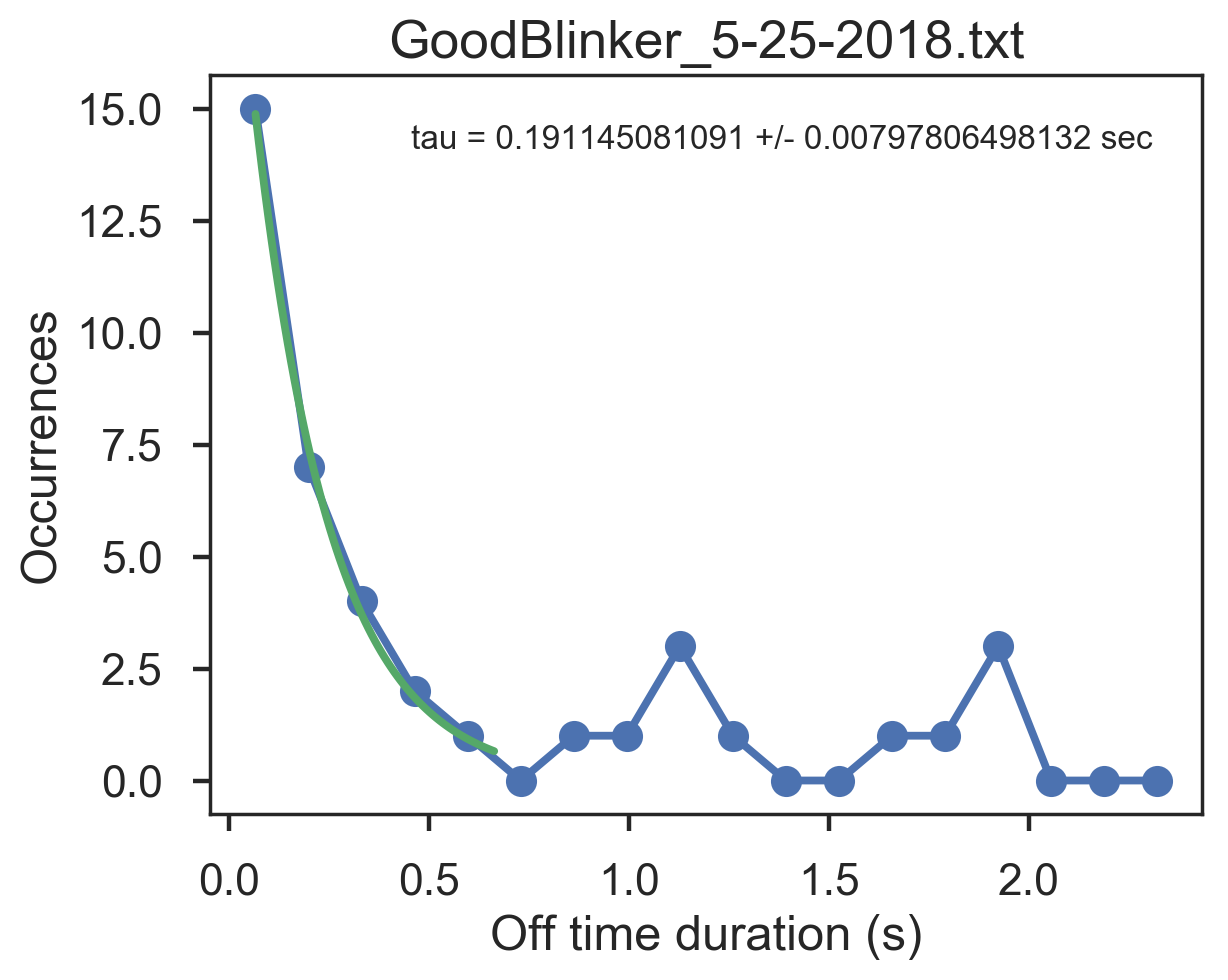

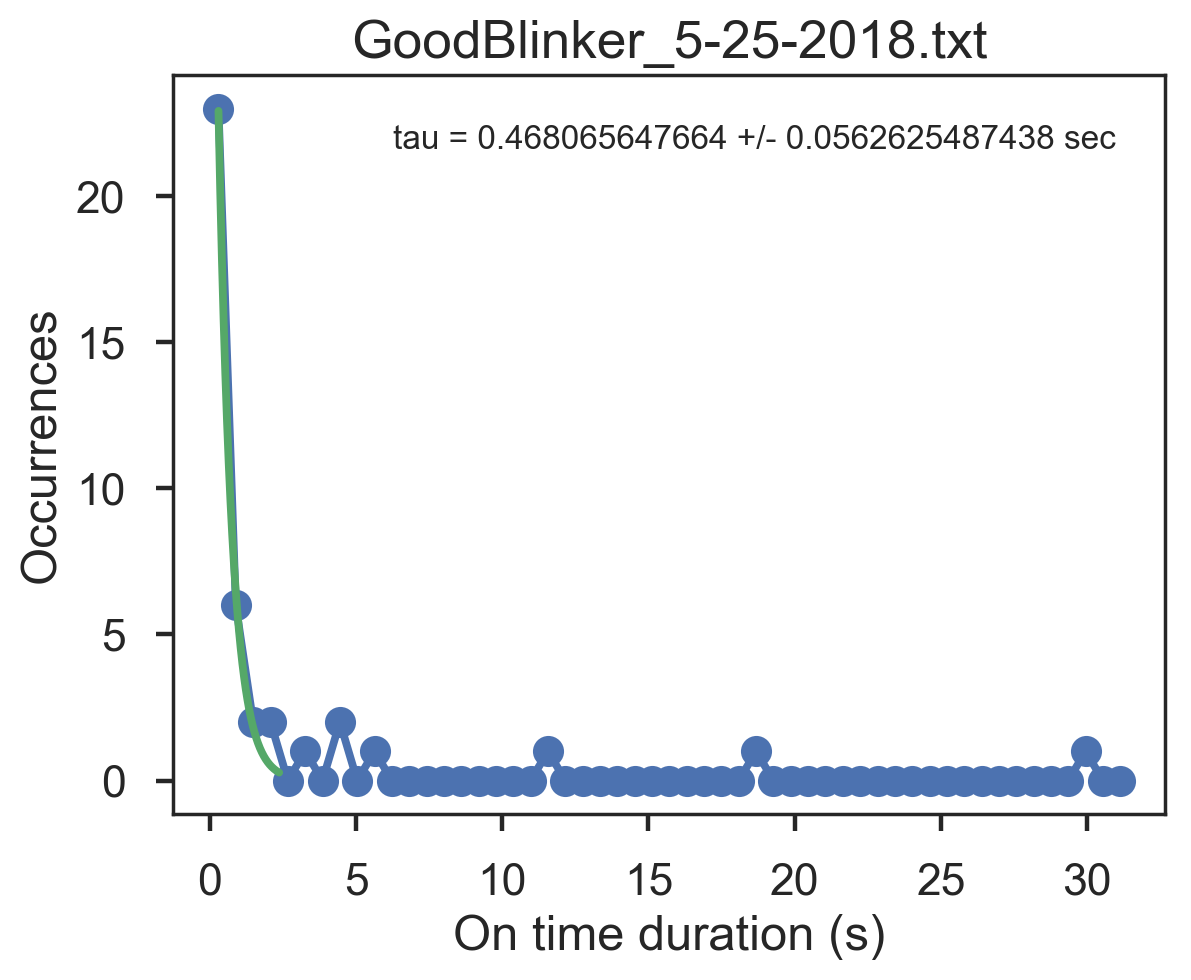

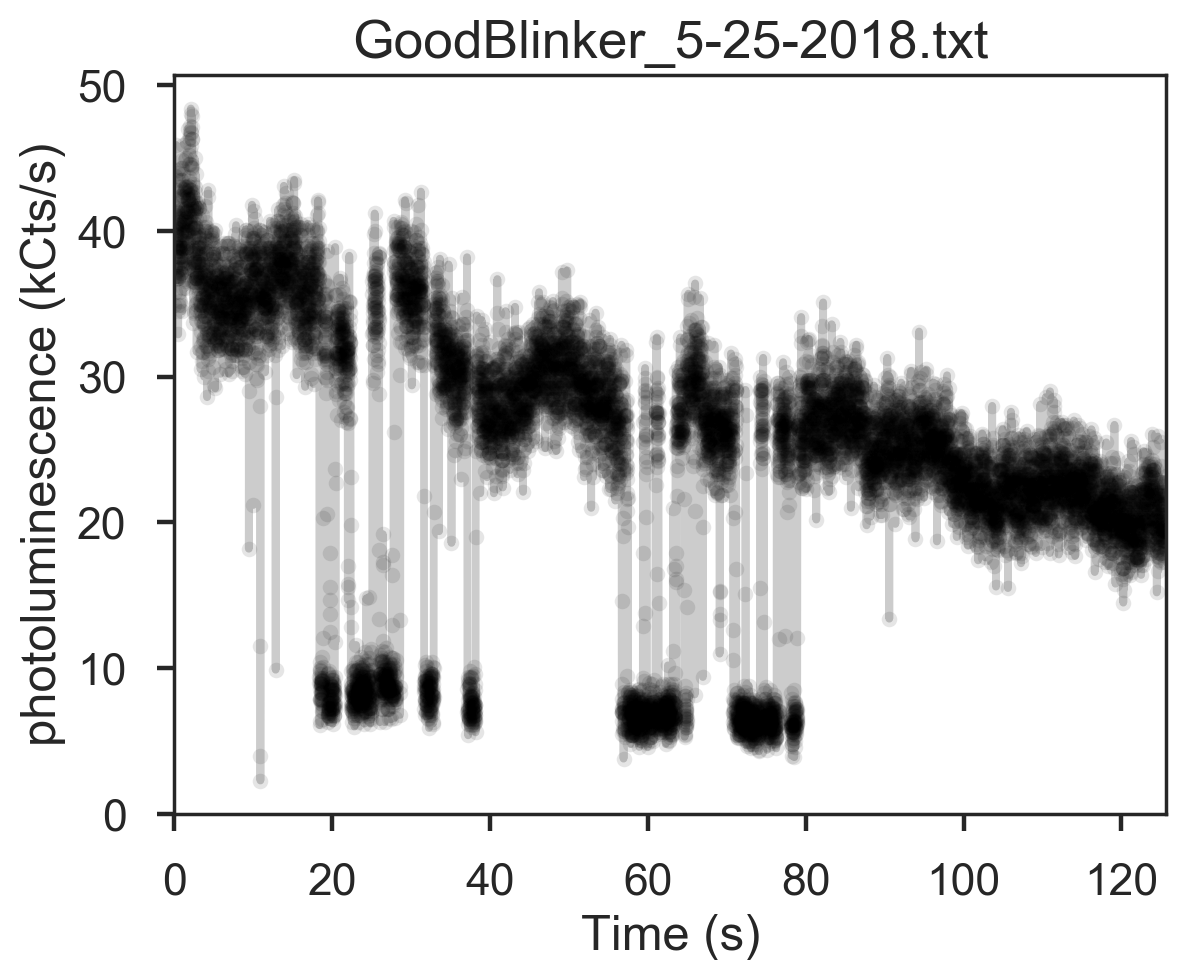

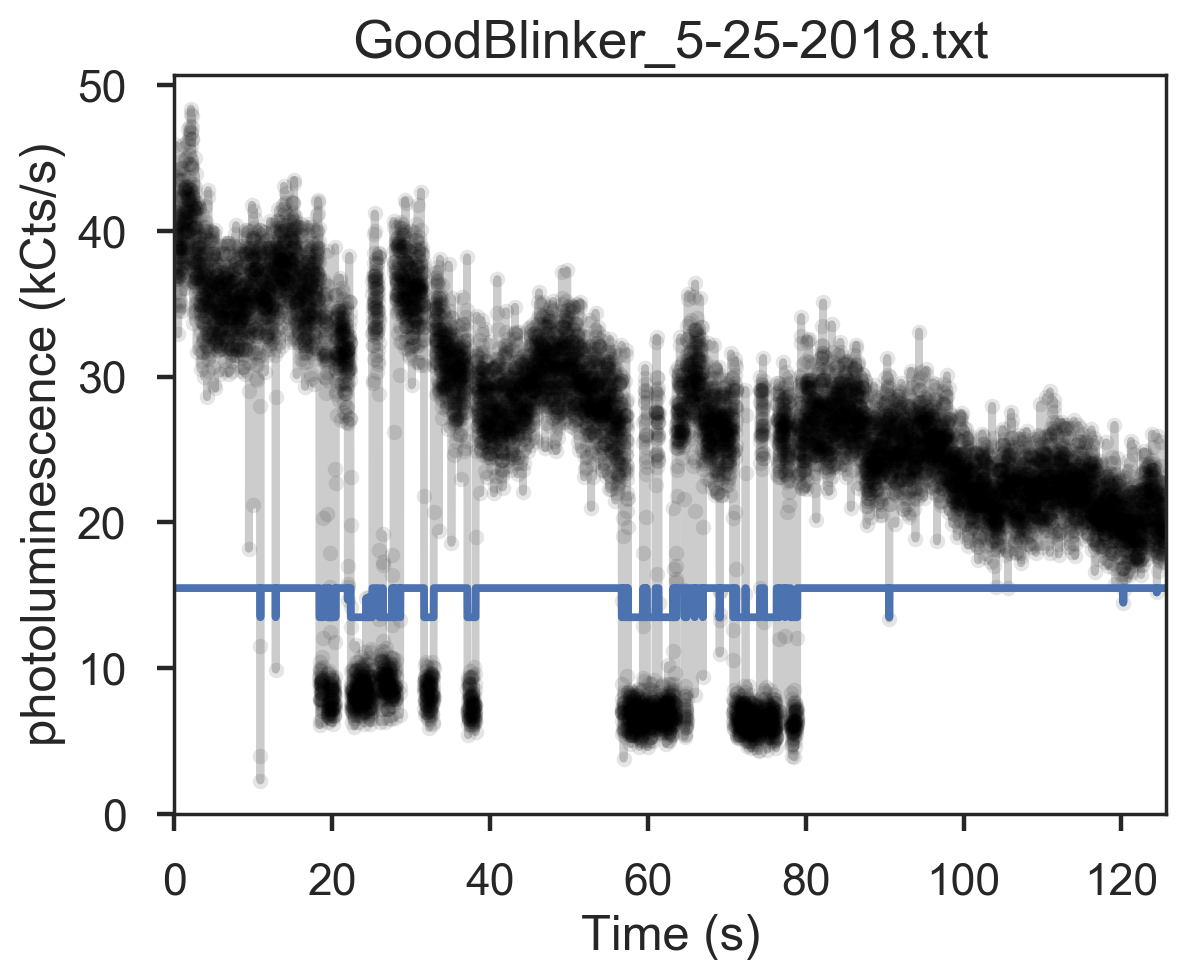

In [39]:
# Save figures

mpl.rcParams['figure.dpi'] = 200

font = {'size'   : 22}
plt.rc('font', **font)

infostr = ',fitpast0'

# display off blinks
fig,ax1 = plt.subplots()
ax1.plot(centeredoffbins,offhist[0],'o-')
plt.xlabel('Off time duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(offfitx,offfit)
plt.text(0.95,0.9,'tau = '  + str(offparams[1]) + ' +/- '  + str(np.sqrt(offpcov[1,1])) + ' sec',
         horizontalalignment='right', transform = ax1.transAxes, fontsize=12)
plt.title(filename)

plt.savefig(today + ',' + filename+',offblinks' + infostr + '.pdf', bbox_inches='tight')
plt.savefig(today + ',' + filename+',offblinks' + infostr + '.png', bbox_inches='tight')

print 'off time constant tau = ' + str(offparams[1]) + ' ± ' + str(np.sqrt(offpcov[1,1])) + ' sec'


# On blinks
fig,ax1 = plt.subplots()
ax1.plot(centeredonbins,onhist[0],'o-')
plt.xlabel('On time duration (s)')
plt.ylabel('Occurrences')
#ax1.set_yscale('symlog', linthreshy=1)
ax1.plot(onfitx,onfit)
plt.text(0.95,0.9,'tau = '  + str(onparams[1]) + ' +/- '  + str(np.sqrt(onpcov[1,1])) + ' sec',
         horizontalalignment='right', transform = ax1.transAxes, fontsize=12)
plt.title(filename)

plt.savefig(today + ',' + filename+',onblinks' + infostr + '.pdf', bbox_inches='tight')
plt.savefig(today + ',' + filename+',onblinks' + infostr + '.png', bbox_inches='tight')


print 'on time constant tau = ' + str(onparams[1]) + ' ± ' + str(np.sqrt(onpcov[1,1])) + ' sec'

fig1,axPL = plt.subplots()
#axPL.plot(data, 'k')
#axPL.legend.remove()
data.plot(marker='.',linestyle='None',legend=False, ax=axPL, color='k',  alpha=.1)
data.plot(legend=False, alpha=0.2, ax=axPL, color='k')
plt.ylabel('photoluminescence (kCts/s)')
plt.xlabel(tname)
plt.title(filename)

plt.savefig(today + ',' + filename+',blinking.pdf', bbox_inches='tight')
plt.savefig(today + ',' + filename+',blinking.png', bbox_inches='tight')


fig2,axPL = plt.subplots()
data.plot(marker='.',linestyle='None',legend=False, alpha=0.1, ax=axPL, color='k')
data.plot(legend=False, alpha=0.2, ax=axPL, color='k')
threshdata.plot(legend=False)
plt.ylabel('photoluminescence (kCts/s)')
plt.xlabel(tname)
plt.title(filename)

plt.savefig(today + ',' + filename+',blinkingandthreshold.pdf', bbox_inches='tight')
plt.savefig(today + ',' + filename+',blinkingandthreshold.png', bbox_inches='tight')


plt.show()